# This is notebook about Time series analysis.

#### For this analysis used Los Angeles International Airport dataset. This is a dataset hosted by the city of Los Angeles. The organization has an open data platform found here and they update their information according the amount of data that is brought in. 

#### More about this data you can find here https://www.kaggle.com/cityofLA/los-angeles-international-airport-data .  

In [653]:
# First of all, we need to analyze our dataset.

import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt

In [654]:
df=pd.read_csv("los-angeles-international-airport-passenger-count-by-carrier-type.csv", sep=",", \
              index_col=['ReportPeriod'], parse_dates=['ReportPeriod'])
df=df.drop(["DataExtractDate", "Arrival_Departure", "Domestic_International", "FlightType"], axis=1)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1632 entries, 2006-01-01 to 2018-10-01
Data columns (total 1 columns):
Passenger_Count    1632 non-null int64
dtypes: int64(1)
memory usage: 25.5 KB


,Passenger_Count
ReportPeriod,
2006-01-01,2457
2006-01-01,139728
2006-01-01,1538812
2006-01-01,332
2006-01-01,1280
2006-01-01,742810
2006-01-01,3450
2006-01-01,139021
2006-01-01,1492469


In [655]:
df=df.groupby(["ReportPeriod"]).sum().reset_index()
df['ReportPeriod'] = pd.to_datetime(df['ReportPeriod'])
df=df.set_index('ReportPeriod')

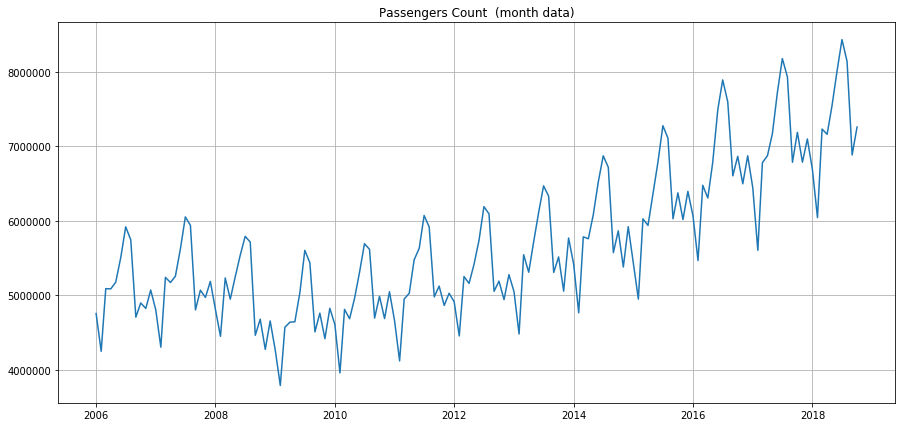

In [656]:
plt.figure(figsize=(15, 7))
plt.plot(df.Passenger_Count)
plt.title('Passengers Count  (month data)')
plt.grid(True)
plt.show()

In [657]:
# We use the MAPE method to assess the quality of the forecast.

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [658]:
# Let's use a time series shift.
# Create a copy of the dataframe for transformations.

data = pd.DataFrame(df.Passenger_Count.copy())
data.columns = ["y"]

In [659]:
# Adding a target variable offset from 1 steps to 17.

for i in range(1, 17):
    data["lag_{}".format(i)] = data.y.shift(i)

In [660]:
data.tail(7)

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16
ReportPeriod,,,,,,,,,,,,,,,,,
2018-04-01,7160368,7230087.0,6043279.0,6687107.0,7097933.0,6785973.0,7186593.0,6785089.0,7930082.0,8176029.0,7726882.0,7167451.0,6874237.0,6779400.0,5604244.0,6444587.0,6872261.0
2018-05-01,7544877,7160368.0,7230087.0,6043279.0,6687107.0,7097933.0,6785973.0,7186593.0,6785089.0,7930082.0,8176029.0,7726882.0,7167451.0,6874237.0,6779400.0,5604244.0,6444587.0
2018-06-01,8012469,7544877.0,7160368.0,7230087.0,6043279.0,6687107.0,7097933.0,6785973.0,7186593.0,6785089.0,7930082.0,8176029.0,7726882.0,7167451.0,6874237.0,6779400.0,5604244.0
2018-07-01,8430430,8012469.0,7544877.0,7160368.0,7230087.0,6043279.0,6687107.0,7097933.0,6785973.0,7186593.0,6785089.0,7930082.0,8176029.0,7726882.0,7167451.0,6874237.0,6779400.0
2018-08-01,8137410,8430430.0,8012469.0,7544877.0,7160368.0,7230087.0,6043279.0,6687107.0,7097933.0,6785973.0,7186593.0,6785089.0,7930082.0,8176029.0,7726882.0,7167451.0,6874237.0
2018-09-01,6882524,8137410.0,8430430.0,8012469.0,7544877.0,7160368.0,7230087.0,6043279.0,6687107.0,7097933.0,6785973.0,7186593.0,6785089.0,7930082.0,8176029.0,7726882.0,7167451.0
2018-10-01,7257286,6882524.0,8137410.0,8430430.0,8012469.0,7544877.0,7160368.0,7230087.0,6043279.0,6687107.0,7097933.0,6785973.0,7186593.0,6785089.0,7930082.0,8176029.0,7726882.0


In [661]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


tscv = TimeSeriesSplit(n_splits=5)

In [662]:
# Divide into training and test set.

def timeseries_train_test_split(X, y, test_size):
    
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [663]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [664]:
# Use Linear regression.

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [665]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

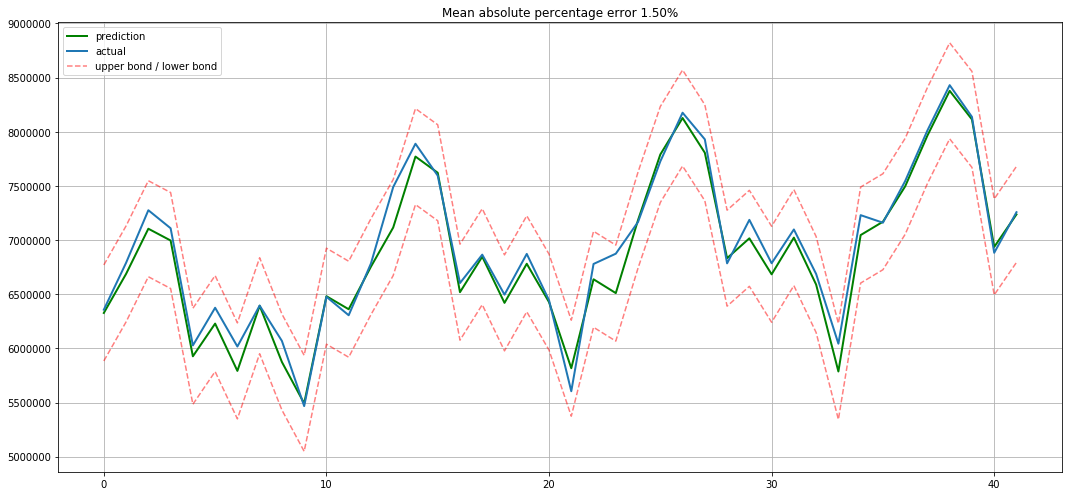

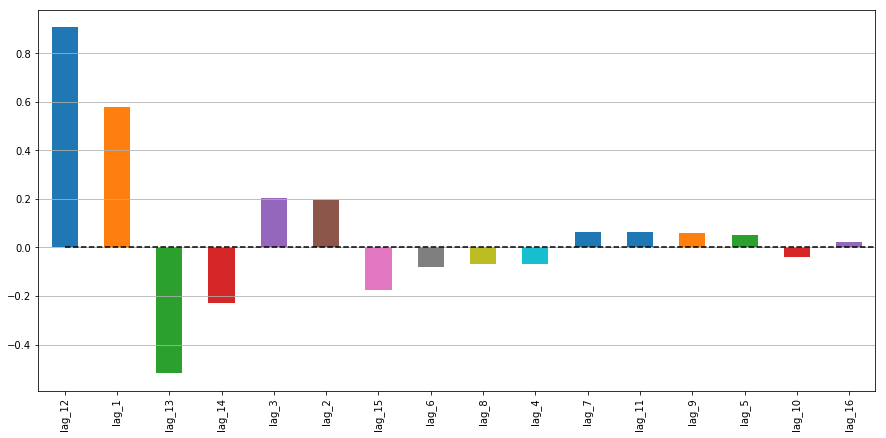

In [666]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [668]:
# Let's create a new dataframe and add the day of the week and weekend as categorical variables.

data.index = pd.to_datetime(data.index)
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
#data=data.drop(["hour"], axis=1)
data.tail()

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,weekday,is_weekend
ReportPeriod,,,,,,,,,,,,,,,,,,,
2018-06-01,8012469,7544877.0,7160368.0,7230087.0,6043279.0,6687107.0,7097933.0,6785973.0,7186593.0,6785089.0,7930082.0,8176029.0,7726882.0,7167451.0,6874237.0,6779400.0,5604244.0,4,0
2018-07-01,8430430,8012469.0,7544877.0,7160368.0,7230087.0,6043279.0,6687107.0,7097933.0,6785973.0,7186593.0,6785089.0,7930082.0,8176029.0,7726882.0,7167451.0,6874237.0,6779400.0,6,1
2018-08-01,8137410,8430430.0,8012469.0,7544877.0,7160368.0,7230087.0,6043279.0,6687107.0,7097933.0,6785973.0,7186593.0,6785089.0,7930082.0,8176029.0,7726882.0,7167451.0,6874237.0,2,0
2018-09-01,6882524,8137410.0,8430430.0,8012469.0,7544877.0,7160368.0,7230087.0,6043279.0,6687107.0,7097933.0,6785973.0,7186593.0,6785089.0,7930082.0,8176029.0,7726882.0,7167451.0,5,1
2018-10-01,7257286,6882524.0,8137410.0,8430430.0,8012469.0,7544877.0,7160368.0,7230087.0,6043279.0,6687107.0,7097933.0,6785973.0,7186593.0,6785089.0,7930082.0,8176029.0,7726882.0,0,0


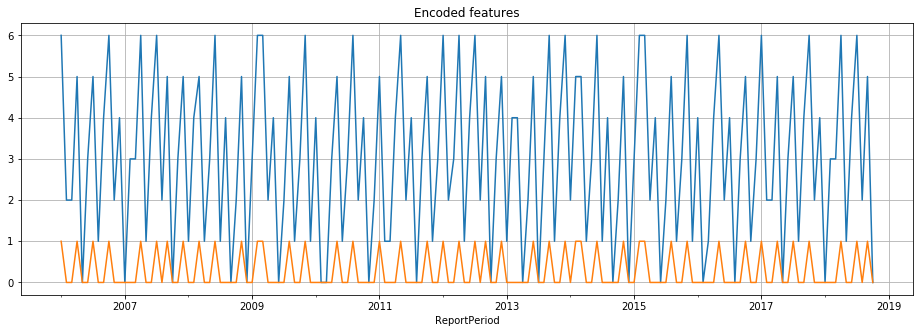

In [636]:
# Visualize by day of the week.

plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

In [669]:
# Convert the new dataframe

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


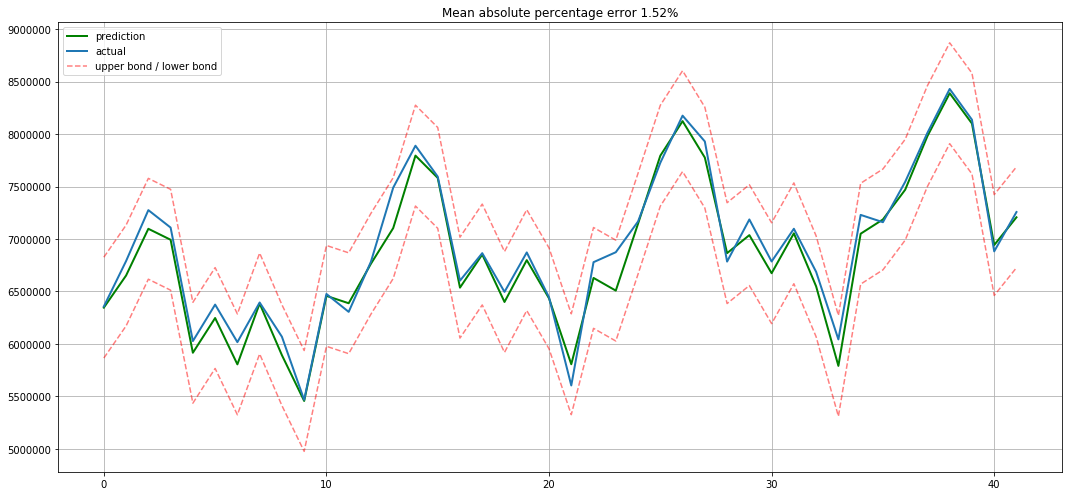

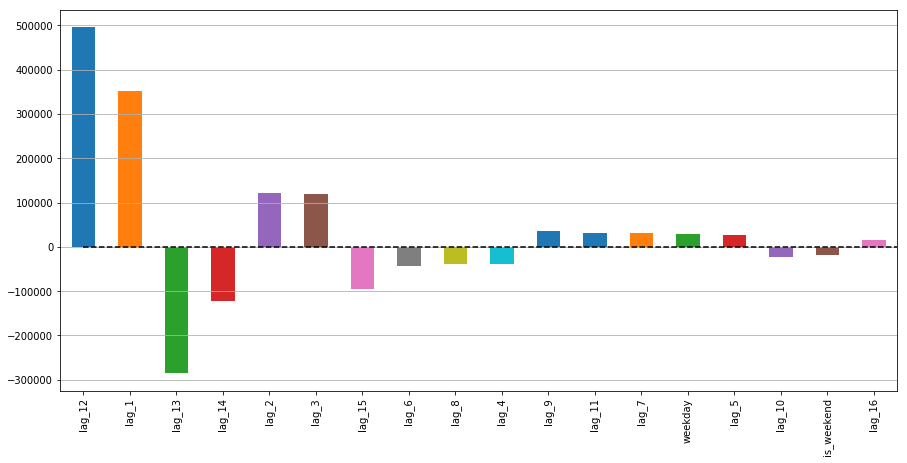

In [670]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

In [671]:
# Let's try coding the target variable by mean.

def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

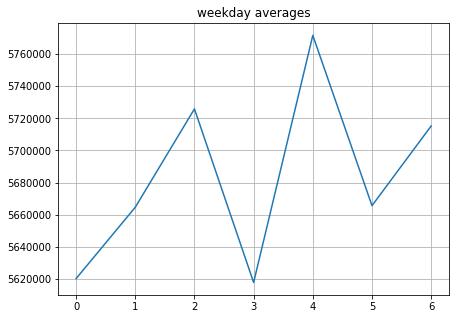

In [672]:
average_hour = code_mean(data, 'weekday', "y")
plt.figure(figsize=(7, 5))
plt.title("weekday averages")
pd.DataFrame.from_dict(average_hour, orient='index')[0].plot()
plt.grid(True);

In [674]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    data.index = pd.to_datetime(data.index)
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # высчитываем среднее значение только на тренировочной части
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))

        
        data.drop(["weekday"], axis=1, inplace=True)
    
    # деление на train-test
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

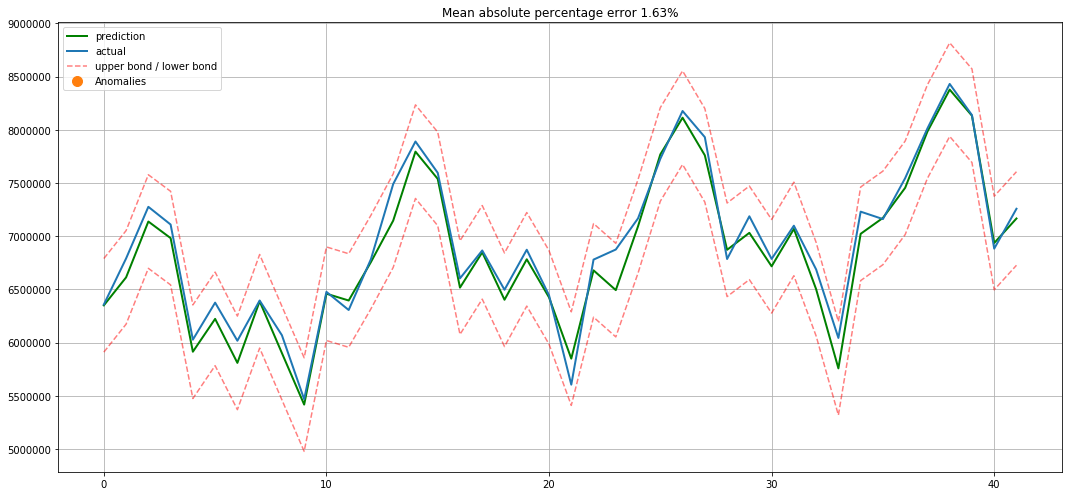

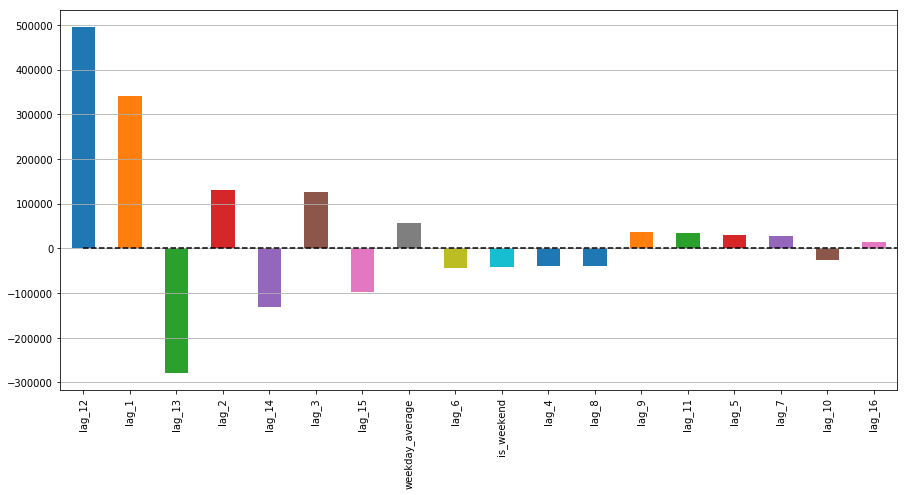

In [675]:
X_train, X_test, y_train, y_test = prepareData(df.Passenger_Count, lag_start=1, lag_end=17, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

In [643]:
X_train, X_test, y_train, y_test =\
prepareData(df.Passenger_Count, lag_start=1, lag_end=17, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

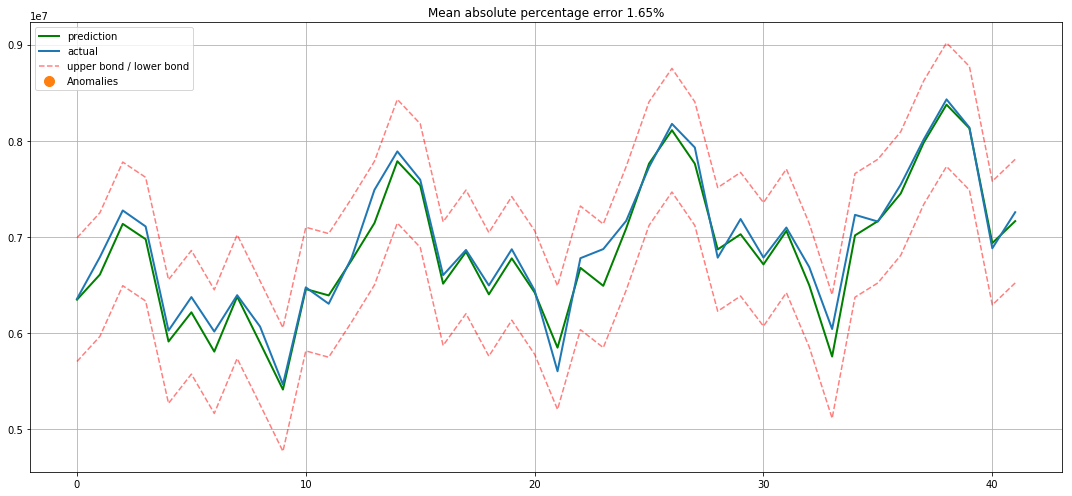

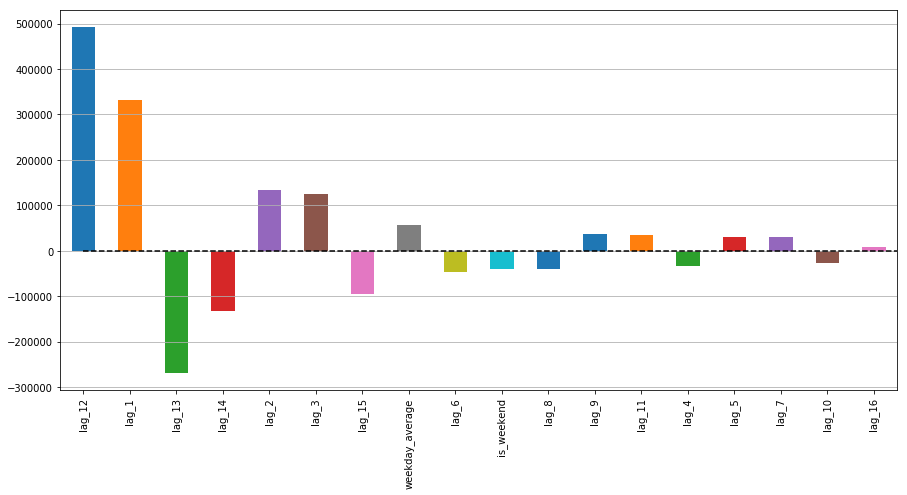

In [676]:
# Let's try to use Ridge and Lasso regularization.

from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

In [679]:
# And finally we use XGBOOST.

from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

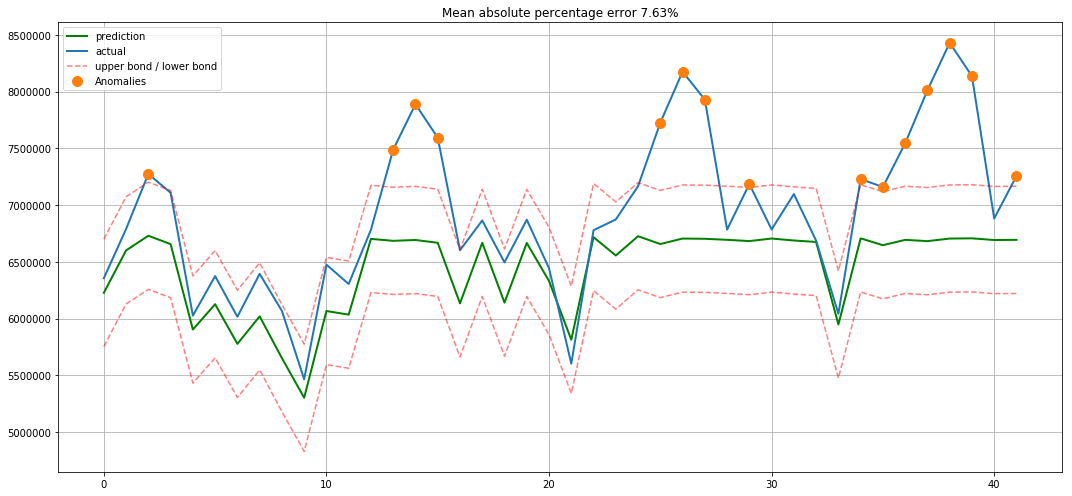

In [680]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)


#### Time series shifts and linear regression predict 1.50% error, which is the best result achieved.